# AutoEncoder to Enhancing Noise Images

Project Outline :  
1. Put the noise on the pictures based on the random value from Gaussian Normal Distribussion using 0.0 mean and 0.1 standard deviation
2. Build an autoencoder deep learning architecture to removing the noised images to the normal one  
3. Fine tuning the architecture to get the best architecture based on the SSIM Evaluation Metrics

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image

import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [4]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)

In [5]:
target_size = 100
batch_size = 32

noise_mean = 0.0
noise_std = 0.1

In [ ]:
df_path = "G:/My Drive/1. Binus University/4th Semester/Deep Learning/UAS/A_23"
images = []
image_paths = []

for filename in os.listdir(df_path):
    img_path = os.path.join(df_path, filename)
    img = Image.open(img_path)
    images.append(np.array(img))
    image_paths.append(img_path)

# 2.a. Exploratory Data Analysis

## Dataset General Information

### 1. Images Frequency on Dataset

In [7]:
print("There are total", len(images), "images.")

There are total 1074 images.


### 2. Images Dimension

In [27]:
def images_dimension(images):
    shapes = [img.shape for img in images if img is not None]
    
    heights = [shape[0] for shape in shapes]
    widths = [shape[1] for shape in shapes]
    channels = [shape[2] if len(shape) == 3 else 1 for shape in shapes]

    print("=== Image Dimension Summary ===")
    print(f"Height : min -> {min(heights)}, max -> {max(heights)}")
    print(f"Width  : min -> {min(widths)}, max -> {max(widths)}")
    print(f"Channels Detected: {set(channels)}")

images_dimension(images)

=== Image Dimension Summary ===
Height : min -> 600, max -> 600
Width  : min -> 600, max -> 600
Channels Detected: {3}


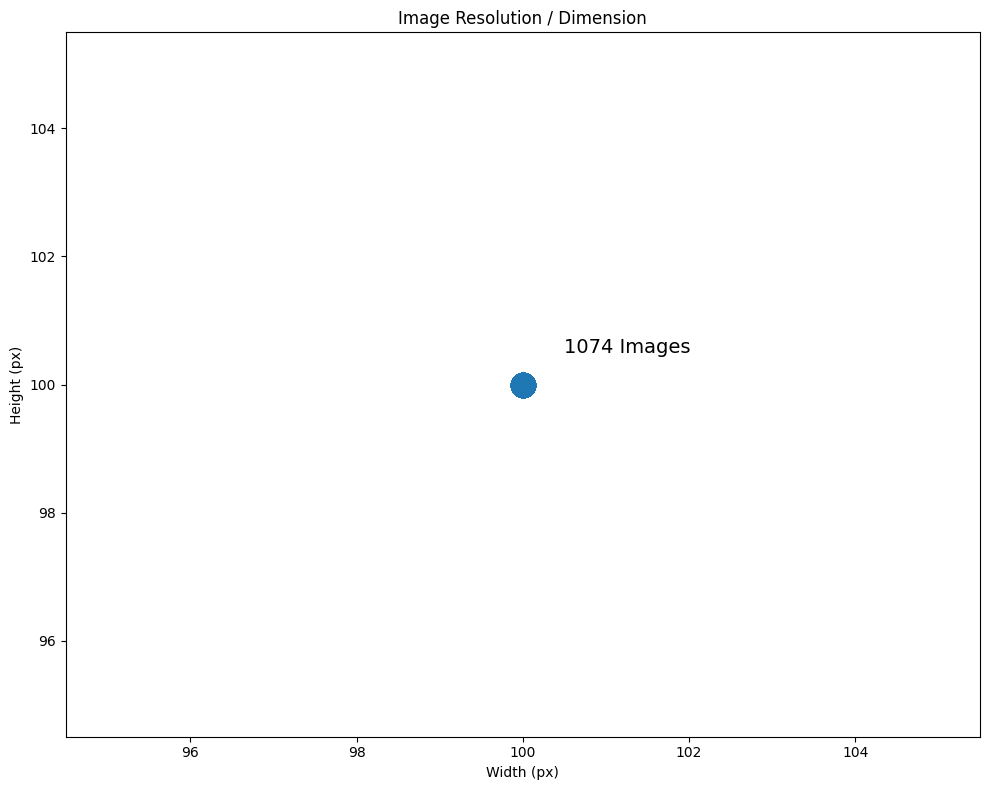

In [31]:
plt.figure(figsize=(10, 8))

plt.scatter(widths, heights, s=300)
plt.title("Image Resolution / Dimension")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.annotate(f"{len(images)} Images", 
             xy = (widths[0], heights[0]),
             xytext=(widths[0]+0.5, heights[0]+0.5),
             fontsize = 14)
plt.tight_layout()
plt.show()

The graph visualized that all of the 1074 images contained on the dataset has the 100x100 ratio, the same value between resolution and dimension indicates the valid dimension of whole images.

### 3. Images Ratio

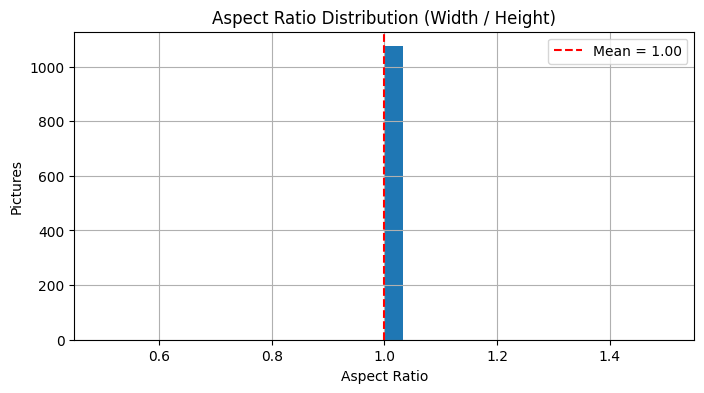

In [9]:
aspect_ratio = []
for path in image_paths:
    img = cv2.imread(path)
    h, w = img.shape[:2]
    ratio = w/h
    aspect_ratio.append(ratio)

plt.figure(figsize=(8,4))
plt.hist(aspect_ratio, bins = 30)
plt.axvline(np.mean(aspect_ratio), color = 'red', linestyle = '--', label = f'Mean = {np.mean(aspect_ratio):.2f}')
plt.title("Aspect Ratio Distribution (Width / Height)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Pictures")
plt.grid(True)
plt.legend()
plt.show()

The graphs visualized that all images ratio are 1:1

## Few Sample of Images

In [10]:
n_samples = min(6, len(images))
sample_indices = np.random.choice(len(images), n_samples, replace = False)

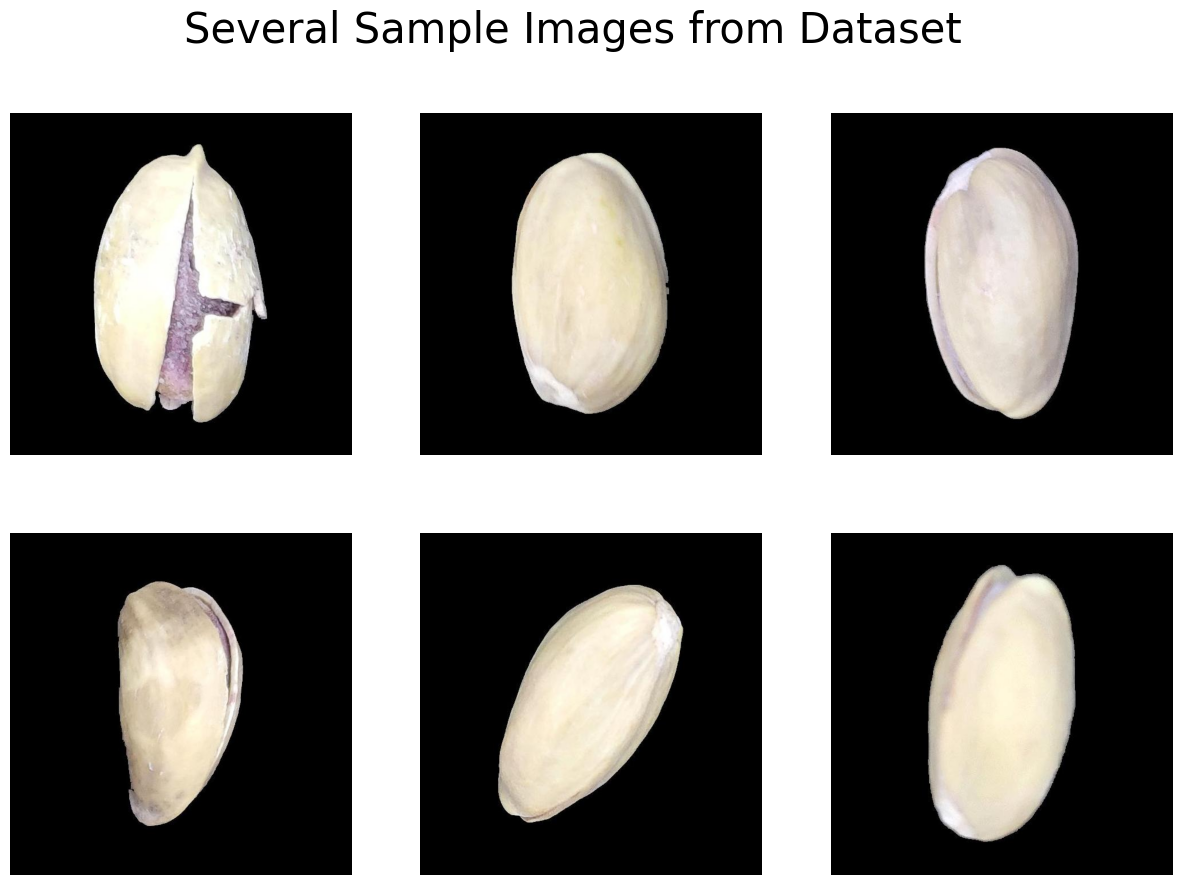

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
fig.suptitle("Several Sample Images from Dataset", fontsize = 30)

for i, idx in enumerate(sample_indices):
    row = i // 3
    col = i % 3

    axes[row, col].imshow(images[idx])
    axes[row, col].axis("off")

plt.show()

## Color Histogram Distribution

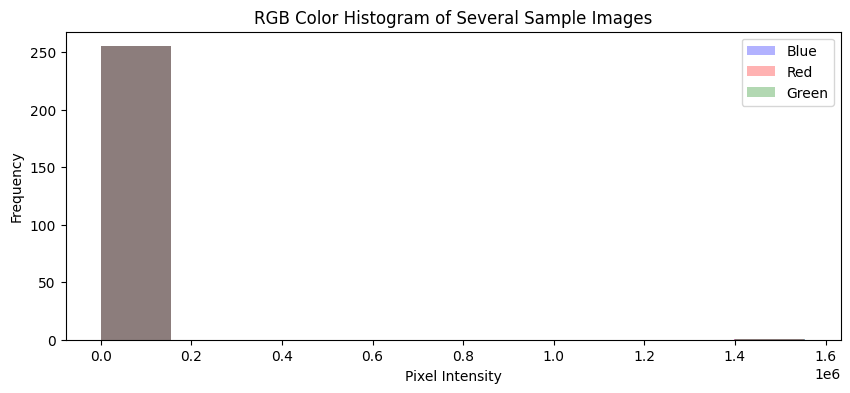

In [12]:
r_hist = np.zeros(256)
g_hist = np.zeros(256)
b_hist = np.zeros(256)
hist_arrays = [r_hist, g_hist, b_hist]

for idx in sample_indices:
    img_path = image_paths[idx]
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for i in range(3):
        hist = cv2.calcHist([img_rgb], [i], None, [256], [0,256]).flatten()
        hist_arrays[i] += hist

plt.figure(figsize=(10,4))
plt.hist(b_hist, bins = 10, color='b', alpha = 0.3, label='Blue')
plt.hist(r_hist, bins = 10, color='r', alpha = 0.3,  label='Red')
plt.hist(g_hist, bins = 10, color='g', alpha = 0.3, label='Green')
plt.title("RGB Color Histogram of Several Sample Images")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The graphs shows the value of pixel's intensity of the whole image dataset.  
* All of the red, green and blue stacked on the same location, means that the colour has identic low distribution pixels which indicates that the image on dataset has a dark color.
* There are very less distribution on the top right because the images still hasnt been normalized

## Image's Contrasity

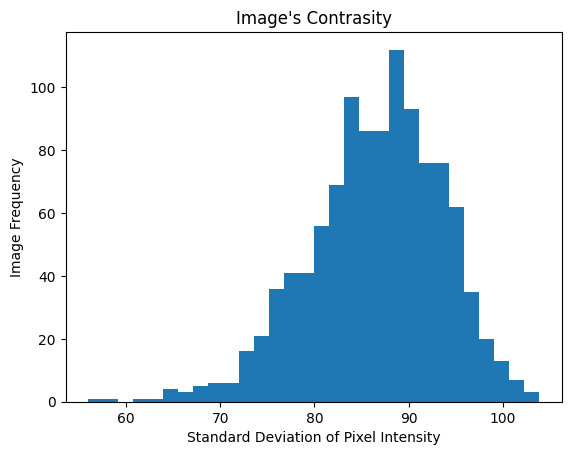

In [13]:
def check_contrasity(image_list):
    contrasity = []

    for img in image_list:
        std_dev = np.std(img)
        contrasity.append(std_dev)

    plt.hist(contrasity, bins=30)
    plt.title("Image's Contrasity")
    plt.xlabel("Standard Deviation of Pixel Intensity")
    plt.ylabel("Image Frequency")
    plt.show()

check_contrasity(images)

Histogram patterened bell-shape with 85-95 as the mean value, meaning the majority image has pixel's standard deviation on that value, and indicates that the images are not too flat nor too contras, but has a semi-balanced contrasity

## Image's Intensity

In [14]:
def plot_intensity(img_path):
    sum = []

    for path in img_path:
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        R = img_rgb[:,:,0]
        G = img_rgb[:,:,1]
        B = img_rgb[:,:,2]

        intensity = 0.299 * R + 0.587 * G + 0.114 * B

        sum.extend(intensity.flatten())

    plt.figure(figsize=(8, 4))
    plt.hist(sum, bins=256, color='gray')
    plt.title("Combined Grayscale Intensity Histogram")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Image Frequency")
    plt.show()

#plot_intensity(image_paths)

* A peak on left side of the histogram indicates many areas in the image are dark and underexposure. 
* A peak on the right side signifies the presence of many bright areas or highlights. 
* In the center range, it means the image has balanced lighting, indicating proper exposure and a well-distributed range of pixel intensities.

## EDA Purposes

EDA Process on Image Data is aims to :   
1. Determine the preprocessing strategy, especially for resize and normalization
2. Ensuring the consistency of input data for model training

# 2.b. Data Preprocess

## Image Resizing

In [36]:
images = []

for path in image_paths:
    img = cv2.imread(path)
    resized_image = cv2.resize(img, (target_size, target_size))
    images.append(np.array(resized_image))

In [37]:
shapes = [img.shape for img in images]
heights = [shape[0] for shape in shapes]
widths = [shape[1] for shape in shapes]
channels = [shape[2] if len(shape) == 3 else 1 for shape in shapes]

print("=== Image Dimension ===")
print(f"Height: min -> {min(heights)}, max -> {max(heights)}")
print(f"Width: min -> {min(widths)}, max= -> {max(widths)}")
print(f"Channels: {set(channels)}")

=== Image Dimension ===
Height: min -> 100, max -> 100
Width: min -> 100, max= -> 100
Channels: {3}


## Image Normalization

In [38]:
for i in range(len(images)):
    images[i] = images[i].astype(np.float32) / 255.0

x = np.array(images)
x.shape

(1074, 100, 100, 3)

## Image Splitting

In [44]:
x_train, x_temp = train_test_split(x, test_size=0.2, random_state=SEED)
print(x_train.shape)
print(x_temp.shape)

(859, 100, 100, 3)
(215, 100, 100, 3)


In [45]:
x_val, x_test = train_test_split(x_temp, test_size=0.5, random_state=SEED)
print(x_val.shape)
print(x_test.shape)

(107, 100, 100, 3)
(108, 100, 100, 3)


## Gaussian Noise Generation

In [46]:
def gaussian_noise(images, mean=noise_mean, std=noise_std):
    noisy_images = []
    for img in images:
        noise = np.random.normal(mean, std, img.shape)
        noisy_img = img + noise
        noisy_img = np.clip(noisy_img, 0.0, 1.0)
        noisy_images.append(noisy_img)
    return np.array(noisy_images)

### || Applying Noise Gaussian to All Set of Data

In [47]:
X_train_noisy = gaussian_noise(x_train, noise_mean, noise_std)
X_val_noisy = gaussian_noise(x_val, noise_mean, noise_std)
X_test_noisy = gaussian_noise(x_test, noise_mean, noise_std)

### || Visualize the Noise Gaussian

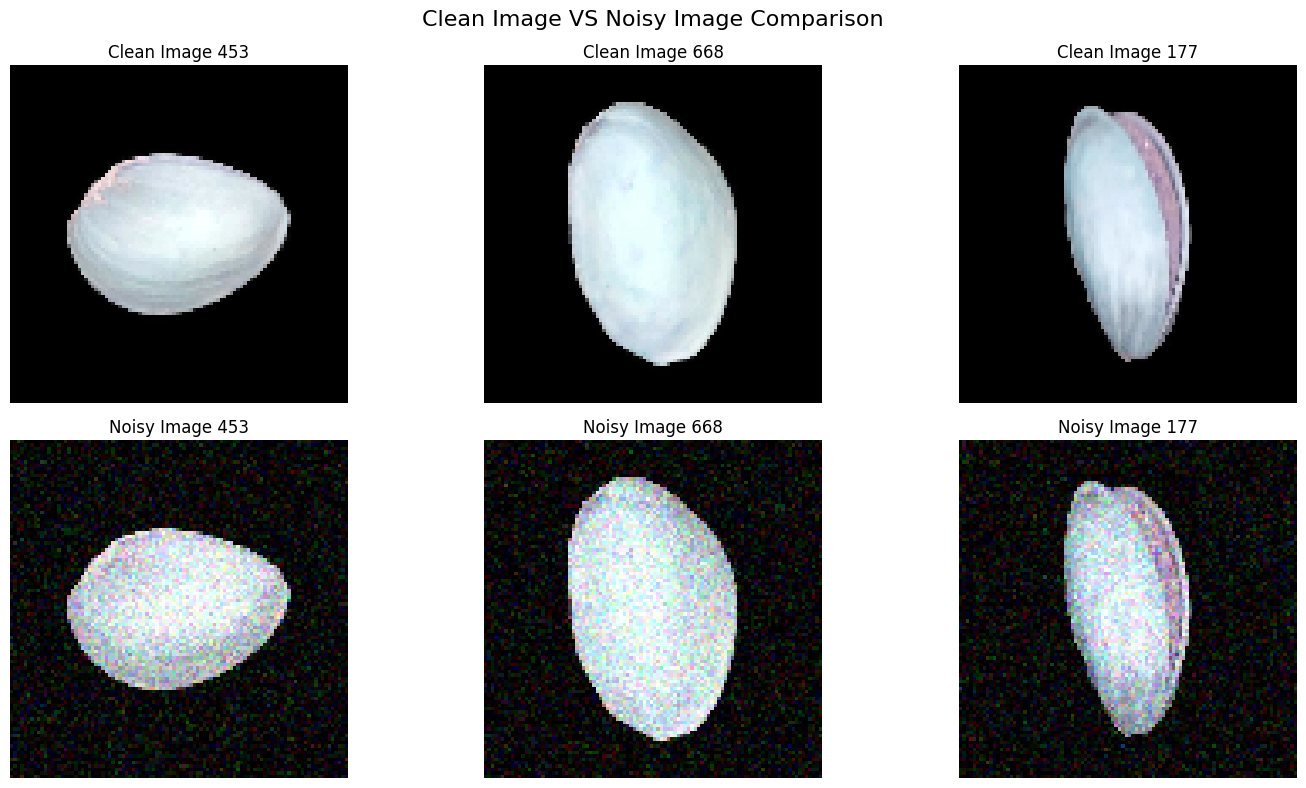

In [52]:
n_samples = 3
sample_indices = np.random.choice(len(x_train), n_samples, replace=False)

fig, axes = plt.subplots(2, n_samples, figsize=(15, 8))
fig.suptitle('Clean Image VS Noisy Image Comparison', fontsize=16)

for i, idx in enumerate(sample_indices):
    # Gambar bersih
    axes[0, i].imshow(x_train[idx])
    axes[0, i].set_title(f'Clean Image {idx+1}')
    axes[0, i].axis('off')
    
    # Gambar dengan noise
    axes[1, i].imshow(X_train_noisy[idx])
    axes[1, i].set_title(f'Noisy Image {idx+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# 2.c. Autoencoder Modelling

The base autoencoder architecture consists of : 
* 3x3 Kernel Size
* Relu Activation Function, besides of Output Layer using Sigmoid
* Adam Optimizer
* MSE Loss Function

In [60]:
input_layer = Input(shape=(100,100,3))

x = Conv2D(32, (3,3), activation = 'relu', padding='same')(input_layer)
x = MaxPooling2D((2,2), padding = 'same')(x)
x = Conv2D(64, (3,3), activation = 'relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)

x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)

output_layer = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

base_autoencoder = Model(inputs=input_layer, outputs=output_layer)
base_autoencoder.compile(optimizer = Adam(), loss = 'mse')
base_autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
history = base_autoencoder.fit(X_train_noisy, x_train, validation_data=(X_val_noisy, x_val), epochs = 30)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.1358 - val_loss: 0.0151
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0140 - val_loss: 0.0122
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0165 - val_loss: 0.0151
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0138 - val_loss: 0.0094
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0062 - val_loss: 0.0039
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - loss: 0

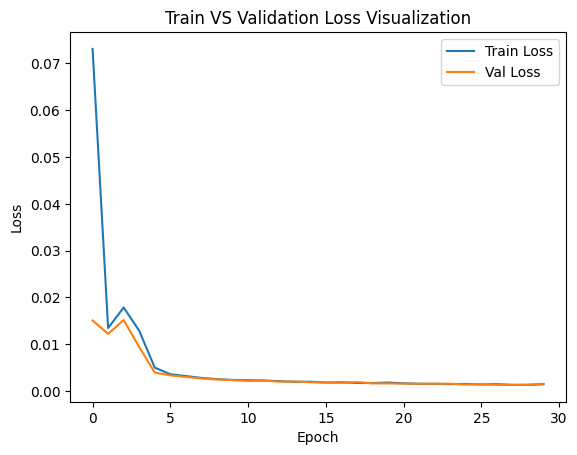

In [62]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.title("Train VS Validation Loss Visualization")
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 2.d. Modification Autoencoder Models

## Modification | 1

**Things to modified :**  
Adding skip connection from encoder to decoder on the base model architecture, similar to **U-Net** Architecture

**Purpose :**   
1. Important Information Disappearing Anticipation on Downsampling layer
2. Boost the performance of loss function

In [71]:
input_layer = Input(shape=(100,100,3))

x1 = Conv2D(32,(3,3), activation='relu', padding='same')(input_layer)
p1 = MaxPooling2D((2,2), padding='same')(x1)
x2 = Conv2D(64,(3,3), activation='relu', padding='same')(p1)
p2 = MaxPooling2D((2,2), padding='same')(x2)

bottleneck = Conv2D(64,(3,3), activation='relu', padding='same')(p2)

u1 = UpSampling2D((2,2))(bottleneck)
concat1 = Concatenate()([u1, x2])
x3 = Conv2D(32,(3,3), activation='relu', padding='same')(concat1)
u2 = UpSampling2D((2,2))(x3)
concat2 = Concatenate()([u2,x1])
x4 = Conv2D(32,(3,3), activation='relu', padding='same')(concat2)

output_layer = Conv2D(3,(3,3), activation='sigmoid', padding='same')(x4)

modified1_autoencoder = Model(inputs=input_layer, outputs=output_layer)
modified1_autoencoder.compile(optimizer=Adam(), loss='mse')
modified1_autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 100, 100,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 50, 50,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 50, 50,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 25, 25,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 25, 25,    │     36,928 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 50, 50,    │          0 │ conv2d_17[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 50, 50,    │          0 │ up_sampling2d_6[… │
│ (Concatenate)       │ 128)              │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 50, 50,    │     36,896 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 100, 100,  │          0 │ conv2d_18[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100, 100,  │          0 │ up_sampling2d_7[… │
│ (Concatenate)       │ 64)               │            │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 100, 100,  │     18,464 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 100, 100,  │        867 │ conv2d_19[0][0]   │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 112,547 (439.64 KB)

 Trainable params: 112,547 (439.64 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
modified1_history = modified1_autoencoder.fit(X_train_noisy, x_train, validation_data=(X_val_noisy, x_val), epochs = 30)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - loss: 0.1155 - val_loss: 0.0028
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 0.0010 - val_loss: 9.7719e-04
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 9.4147e-04 - val_loss: 8.9118e-04
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - loss: 8.7060e-04 - val_loss: 8.1511e-04
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 302ms/step - loss: 8.1165e-04 - val_loss: 7.3765e-04
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - loss: 7.6248e-04 - val_loss: 6.7782e-04
Epoch 12/30
27/2

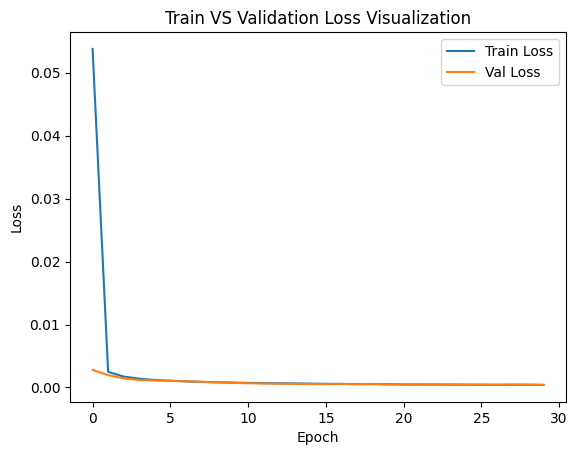

In [73]:
train_loss = modified1_history.history['loss']
val_loss = modified1_history.history['val_loss']
plt.title("Train VS Validation Loss Visualization")
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Modification | 2

**Things to modified :**  
Changing the 3x3 first layer kernel size to 5x5      

**Purpose :**   
1. Make the model more sensitive to the noise pattern that distributed on the image
2. Keep the eficiency dan deepth of the model by keeping the other layers to still using 3x3 kernel size

In [74]:
input_layer = Input(shape=(100,100,3))

x1 = Conv2D(32,(5,5), activation='relu', padding='same')(input_layer)
p1 = MaxPooling2D((2,2), padding='same')(x1)
x2 = Conv2D(64,(3,3), activation='relu', padding='same')(p1)
p2 = MaxPooling2D((2,2), padding='same')(x2)

bottleneck = Conv2D(64,(3,3), activation='relu', padding='same')(p2)

u1 = UpSampling2D((2,2))(bottleneck)
concat1 = Concatenate()([u1, x2])
x3 = Conv2D(32,(3,3), activation='relu', padding='same')(concat1)
u2 = UpSampling2D((2,2))(x3)
concat2 = Concatenate()([u2,x1])
x4 = Conv2D(32,(3,3), activation='relu', padding='same')(concat2)

output_layer = Conv2D(3,(3,3), activation='sigmoid', padding='same')(x4)

modified2_autoencoder = Model(inputs=input_layer, outputs=output_layer)
modified2_autoencoder.compile(optimizer=Adam(), loss='mse')
modified2_autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 100, 100,  │      2,432 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 50, 50,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 50, 50,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 25, 25,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 25, 25,    │     36,928 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_8     │ (None, 50, 50,    │          0 │ conv2d_23[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 50, 50,    │          0 │ up_sampling2d_8[… │
│ (Concatenate)       │ 128)              │            │ conv2d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 50, 50,    │     36,896 │ concatenate_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 100, 100,  │          0 │ conv2d_24[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 100, 100,  │          0 │ up_sampling2d_9[… │
│ (Concatenate)       │ 64)               │            │ conv2d_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 100, 100,  │     18,464 │ concatenate_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 100, 100,  │        867 │ conv2d_25[0][0]   │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 114,083 (445.64 KB)

 Trainable params: 114,083 (445.64 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
modified2_history = modified2_autoencoder.fit(X_train_noisy, x_train, validation_data=(X_val_noisy, x_val), epochs = 30)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - loss: 0.1240 - val_loss: 0.0140
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - loss: 0.0207 - val_loss: 0.0157
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 0.0125 - val_loss: 0.0087
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - loss: 0.0072 - val_loss: 0.0030
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 322ms/ste

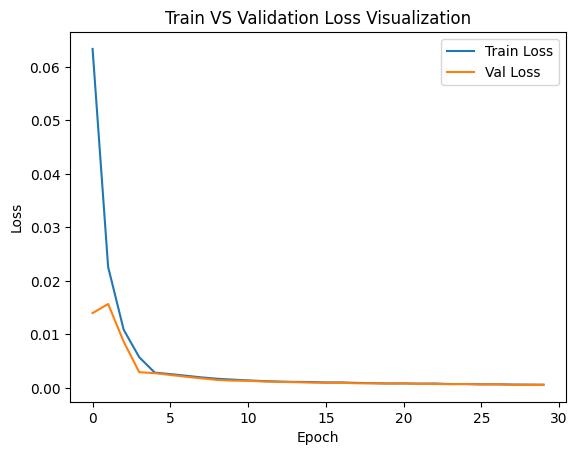

In [76]:
train_loss = modified2_history.history['loss']
val_loss = modified2_history.history['val_loss']
plt.title("Train VS Validation Loss Visualization")
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Modified | 3

**Things to modified :**  
From the 3x3 kernel size (from 1st modification), will change :  
1. Relu untul Leakyrelu activation function  
2. Dropout addition on the bottleneck layer
3. Convert upsampling layer into conv2DTranspose layer 

**Purpose :**   
1. Preventing dead activation, and keeping the model to learning from the smooth noise
2. Preventing model's overfitting
3. Upsampling process can also learn from the parameter with conv2DTranspose layer, aims to smoothening the results of pixel

In [84]:
input_layer = Input(shape=(100,100,3))

x1 = Conv2D(32,(3,3), padding='same')(input_layer)
x1 = LeakyReLU(alpha=0.1)(x1)
p1 = MaxPooling2D((2,2), padding='same')(x1)
x2 = Conv2D(64,(3,3), padding='same')(p1)
x2 = LeakyReLU(alpha=0.1)(x2)
p2 = MaxPooling2D((2,2), padding='same')(x2)

bottleneck = Conv2D(64,(3,3), padding='same')(p2)
bottleneck = LeakyReLU(alpha=0.1)(bottleneck)
bottleneck = Dropout(0.3)(bottleneck)

u1 = Conv2DTranspose(64,(3,3), strides=(2,2), padding='same')(bottleneck)
u1 = LeakyReLU(alpha=0.1)(u1)
concat1 = Concatenate()([u1,x2])
x3 = Conv2D(32,(3,3), padding='same')(concat1)
x3 = LeakyReLU(alpha=0.1)(x3)
u2 = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(x3)
u2 = LeakyReLU(alpha=0.1)(u2)
concat2 = Concatenate()([u2,x1])
x4 = Conv2D(32,(3,3),padding='same')(concat2)
x4 = LeakyReLU(alpha=0.1)(x4)

output_layer = Conv2D(3,(3,3), activation='sigmoid', padding='same')(x4)
modified3_autoencoder = Model(inputs=input_layer, outputs=output_layer)
modified3_autoencoder.compile(optimizer=Adam(), loss='mse')
modified3_autoencoder.summary()

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 100, 100,  │        896 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_21      │ (None, 100, 100,  │          0 │ conv2d_42[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 50, 50,    │          0 │ leaky_re_lu_21[0… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 50, 50,    │     18,496 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_22      │ (None, 50, 50,    │          0 │ conv2d_43[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 25, 25,    │          0 │ leaky_re_lu_22[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 25, 25,    │     36,928 │ max_pooling2d_17… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_23      │ (None, 25, 25,    │          0 │ conv2d_44[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 25, 25,    │          0 │ leaky_re_lu_23[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 50, 50,    │     36,928 │ dropout_3[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_24      │ (None, 50, 50,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 50, 50,    │          0 │ leaky_re_lu_24[0… │
│ (Concatenate)       │ 128)              │            │ leaky_re_lu_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 50, 50,    │     36,896 │ concatenate_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_25      │ (None, 50, 50,    │          0 │ conv2d_45[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 100, 100,  │      9,248 │ leaky_re_lu_25[0… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_26      │ (None, 100, 100,  │          0 │ conv2d_transpose

 Total params: 158,723 (620.01 KB)

 Trainable params: 158,723 (620.01 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
modified3_history = modified3_autoencoder.fit(X_train_noisy, x_train, validation_data=(X_val_noisy, x_val), epochs = 30)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - loss: 0.1462 - val_loss: 0.0035
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - loss: 0.0010 - val_loss: 9.3167e-04
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - loss: 9.4099e-04 - val_loss: 8.8056e-04
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - loss: 9.1760e-04 - val_loss: 8.1438e-04
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - loss: 8.4060e-04 - val_loss: 7.7652e-04
Epoch 12/30
27/27 ━━

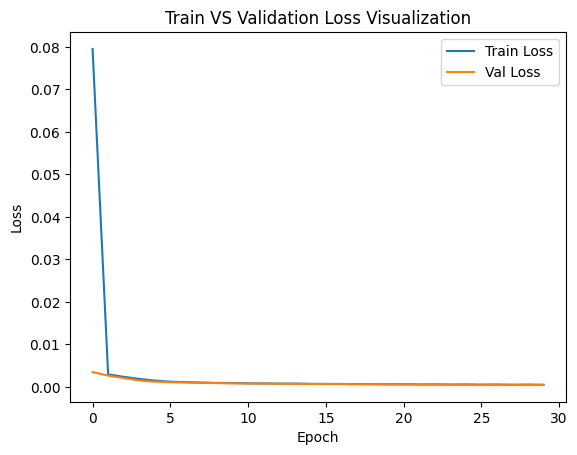

In [86]:
train_loss = modified3_history.history['loss']
val_loss = modified3_history.history['val_loss']
plt.title("Train VS Validation Loss Visualization")
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 2.e. Model Evaluation

In [87]:
models_info = [
    ("Base Autoencoder", base_autoencoder, "Conv2D + MaxPool + UpSampling"),
    ("Modified 1", modified1_autoencoder, "Base Model + Skip Connection (U-Net Characteristics)"),
    ("Modified 2", modified2_autoencoder, "U-Net + Kernel 5x5"),
    ("Modified 3", modified3_autoencoder, "U-Net + Kernel 3x3 + LeakyReLU + Dropout + Conv2DTranspose")
]

In [89]:
ssim_results = []

for name, model, desc in models_info:
    y_pred = model.predict(X_test_noisy)
    mean_ssim, _ = evaluate_ssim(x_test, y_pred)
    ssim_results.append({
        "Model Name": name,
        "Description": desc,
        "SSIM Score": round(mean_ssim, 4)
    })
df_ssim = pd.DataFrame(ssim_results)
df_ssim

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


,Model Name,Description,SSIM Score
0,Base Autoencoder,Conv2D + MaxPool + UpSampling,0.9421
1,Modified 1,Base Model + Skip Connection (U-Net Characteri...,0.9641
2,Modified 2,U-Net + Kernel 5x5,0.9642
3,Modified 3,U-Net + Kernel 3x3 + LeakyReLU + Dropout + Con...,0.9607


The best accuracy model, which contains skip connection + 5x5 Kernel resulted 0.9642 SSIM Scores, it indicates that the un-noised images almost identic with the original images, on the aspects of :   
* Structure, the pattern or shape of the images
* Luminance, the consistent brightness
* Contras, the difference between shadow and highlight

# Final Results

This result contains of comparation between three conditions :   
1. The original dataset
2. The noisy dataset, which is the original dataset added by a Gaussian Noise
3. The output, which is the result of best performance auto encoder, which is the U-Net + Kernel 5x5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


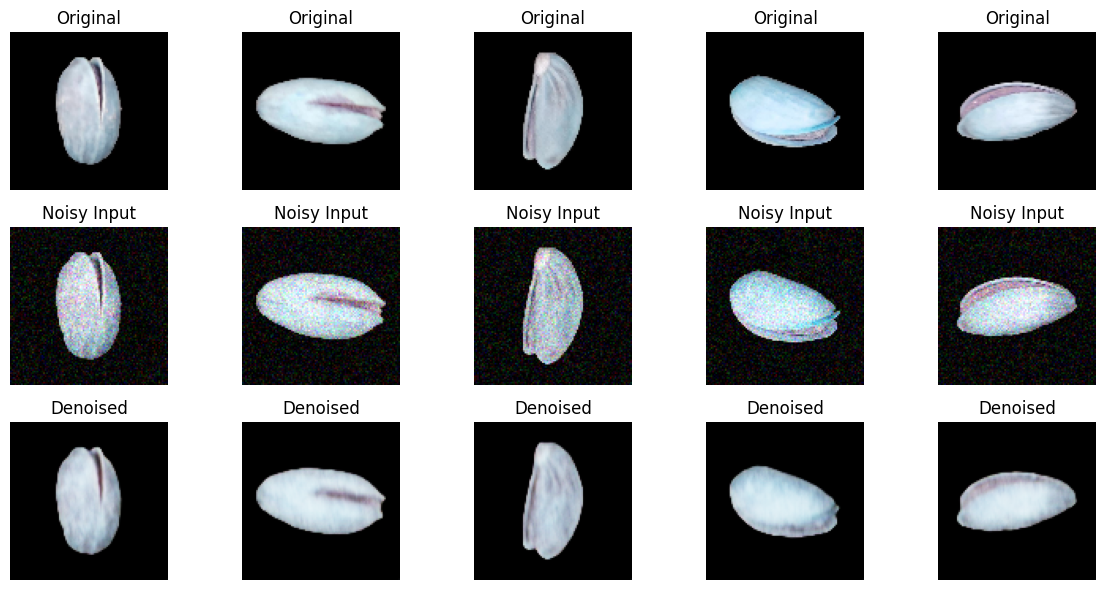

In [96]:
n = 5
indices = np.random.choice(len(X_test_noisy), n, replace=False)

# Prediksi hasil denoising
denoised_imgs = modified2_autoencoder.predict(X_test_noisy[indices])

# Plot
plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    # Original (Ground Truth)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[idx])
    plt.title("Original")
    plt.axis("off")

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test_noisy[idx])
    plt.title("Noisy Input")
    plt.axis("off")
    
    # Denoised Output
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_imgs[i])
    plt.title("Denoised")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Summary

Based on the training and evaluation process, it can be concluded as : 
* The most converge model, alongside with the smallest loss function : 4.1699e-04 from 30 epoch, is the first modified model, which the base model that added with a skip connection from the encoder to the decoder
* The best accurate model is the second modified model, which is the base model, added with skip connection, and changed the kernel size to 5x5 on the input layer, with the 0.9642 SSIM Score.

It indicates that with the addition of skip connection, that have a significant to increase the speed and stability of the training process, on combination with the wider kernel size, that caught a wider image's spatial pattern on the initial stage of learning, may significantly increase the accuracy of the model, which is 96.42% close to the image's original quality.

# Explanation Video

https://drive.google.com/file/d/1kwbZ9IkzT0Pk085YZesE6Q6iqilbMSxZ/view?usp=sharing